<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Introduction-" data-toc-modified-id="1.-Introduction--1">1. Introduction </a></span></li><li><span><a href="#Complaint-Length-" data-toc-modified-id="Complaint-Length--2">Complaint Length </a></span></li><li><span><a href="#Most-Common-Words" data-toc-modified-id="Most-Common-Words-3">Most Common Words</a></span></li><li><span><a href="#Most-Common-Word-Pairs" data-toc-modified-id="Most-Common-Word-Pairs-4">Most Common Word Pairs</a></span></li></ul></div>

In [1]:
# Styling notebookb
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from tqdm.auto import tqdm
from wordcloud import WordCloud
from src.fetch_data import fetch_data
from src.config import app_key

<h1>1. Introduction </h1>

<div class="description">

The purpose of this project is to train a NLP multi-class classification model on building complaints received by the City of San Francisco to effectively predict which division a complaint needs to be assigned to. We will explore a variety of approaches to solving this problem using Tensorflow, Scikit-Learn, Spacy, and NLTK. 

In this exploratory notebook we will load the raw data from the City of San Francisco's API and analyze it to get a better idea of the problem we are solving. We will also do some simple preprocessing to prepare the text for the clean_data notebook which is where the text will be normalized and then tokenized using a Tensorflow tokenizer before it is ready to be used in machine learning. 
    
</div>

<div class="description">

First we run our fetch_data function to fetch the dataset from San Francisco's SODA API and save it to our /data/ directory.   
    
* Note that you need a SODA app key to access the API, here I'm passing mine from my config file.
    
</div>

In [3]:
fetch_data(app_key)

In [48]:
#load data into a Panda's dataframe
working_dir = os.getcwd()
data_path = os.path.dirname(working_dir) + '/data/'
df = pd.read_csv(data_path + 'raw_data.csv', usecols=['complaint_description', 'assigned_division'])

In [49]:
df.head()

,complaint_description,assigned_division
0,Caller reporting that the water is discolored....,Housing Inspection Services
1,Date last observed: 03-oct-17; time last ob...,Building Inspection Division
2,Date last observed: 08-dec-17; exact locati...,Housing Inspection Services
3,Date last observed: 19-aug-17; time last ob...,Building Inspection Division
4,Date last observed: 14-aug-17; time last ob...,Building Inspection Division


In [50]:
#view the shape of our dataset
df.shape

(268628, 2)

In [51]:
#determine how many duplicate entries there are
df.duplicated().sum()

84035

In [52]:
#drop duplicates
df.drop_duplicates(inplace = True)

In [53]:
print("Duplicated: ", df.duplicated().sum())
print("Shape: ", df.shape)

Duplicated:  0
Shape:  (184593, 2)


In [54]:
#ensure datatypes are correct
df.dtypes

complaint_description    object
assigned_division        object
dtype: object

In [55]:
#determine how many complaints there are for each category
df.assigned_division.value_counts()

Housing Inspection Services       87118
Building Inspection Division      63685
Plumbing Inspection Division      16297
Code Enforcement Section          10766
Electrical Inspection Division     5544
Disabled Access Division           1114
Help Desk / Technical Services       33
Department of Bldg Inspection        11
Other/Outside Agency                  9
Department of City Planning           4
Seismic Safety Section                1
Central Permit Bureau                 1
Major Plan Check Division             1
Department of Public Health           1
Name: assigned_division, dtype: int64

<div class="description">
Clearly we are dealing with an imbalanced data set, with virtually half of the complaints belonging to Housing Inspection Services. We will explore different techniques later on to deal with this imbalance like oversampling and using class weights in Tensorflow. We will also utilize transfer learning by using a BERT encoder as the first layer in our final model. This will give the model a much deeper understanding of the text, which will be especially helpful on the classes with less data, like the Disabled Access Division.
    
<br>    
    
The Code Enforcment Division doesn't contain complaints the city received, it is  a log of inspections and infractions, because we are interested in predicting complaints from citizens we will drop it from the dataset. 

<br>
We will also remove the categories that don't have at least 1,000 complaints, focusing on the five most common divisions as the rest are unconsequential.
    
</div>

In [57]:
df = df.groupby("assigned_division").filter(lambda x: len(x) > 1000)
df = df.loc[df['assigned_division'] != 'Code Enforcement Section']

In [59]:
#ensure the dataframe is as expected after dropping columns
df.assigned_division.value_counts()

Housing Inspection Services       87118
Building Inspection Division      63685
Plumbing Inspection Division      16297
Electrical Inspection Division     5544
Disabled Access Division           1114
Name: assigned_division, dtype: int64

In [63]:
#examine a sample of complaint descriptions
display(df.complaint_description.sample(10))

25974     Date last observed: 12-mar-19;    identity of ...
16414     Date last observed: 22-nov-18;    time last ob...
156472    Job card never posted (complainant wants to ap...
181950     Cutting tiles & major renovation without permit.
190752    Ceiling fan damaged from ceiling leak, water d...
140244    There digging holes and are blocking the alley...
267609    Lead base peeling paint all over building and ...
172574      Possible illegal in-law unit located in garage.
139619    Construction inside w/out permits alterations ...
173745      Fence is over 6ft in height. please check asap.
Name: complaint_description, dtype: object

In [62]:
#check for null values
df.isna().sum()

complaint_description    4
assigned_division        0
dtype: int64

In [64]:
#drop any rows that contain null values
df.dropna(inplace = True)

In [65]:
#find the length of the longest complaint
df["complaint_description"].str.len().max()

1000

<h1>Complaint Length </h1>

COMPLAINT LENGTH STATISTICS:
Mean Complaint Length:  150.45421688133797
Min Complaint Length:  1
Max Complaint Length:  1000


Text(0, 0.5, 'Count')

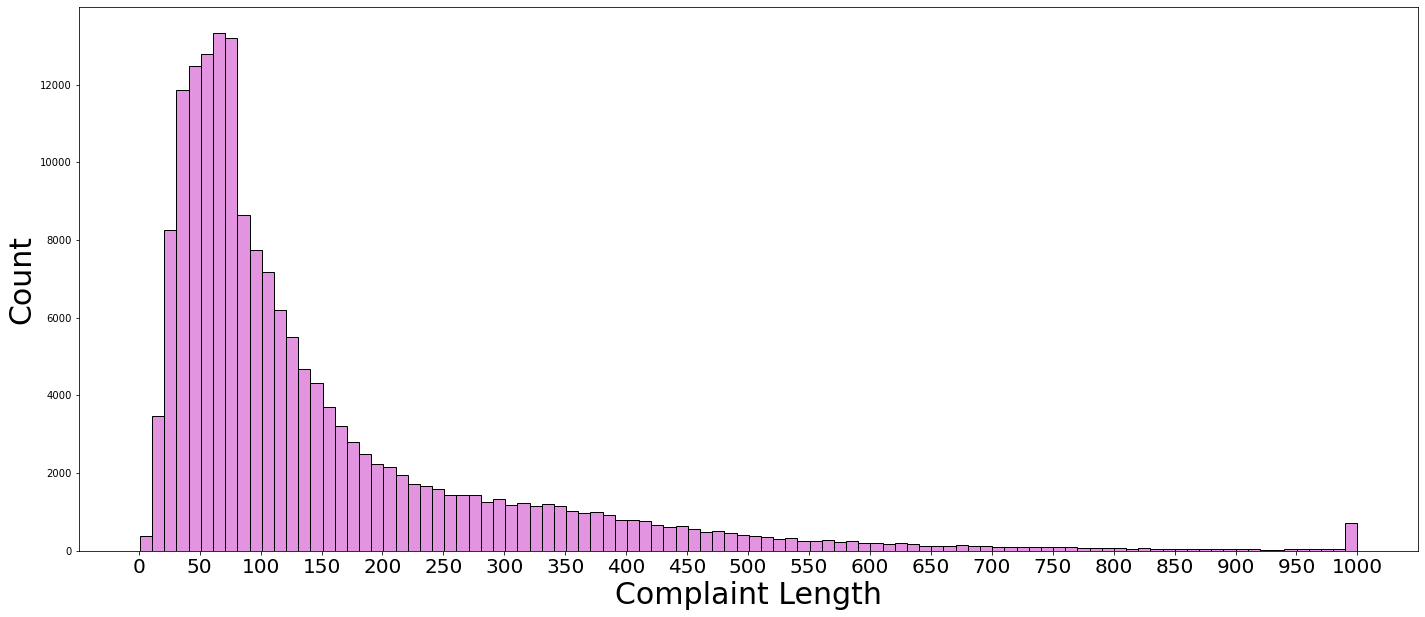

In [66]:
sample = df.copy()
sample['complaint_length'] = sample['complaint_description'].apply(len)
print("COMPLAINT LENGTH STATISTICS:")
print("Mean Complaint Length: ", sample['complaint_length'].mean())
print("Min Complaint Length: ", sample['complaint_length'].min())
print("Max Complaint Length: ", sample['complaint_length'].max())

#plot a histogram of the complaint lengths
fig, ax = plt.subplots(figsize=(24,10))
ax = sns.histplot(data = sample, x='complaint_length', bins = 100, color = "orchid")
xticks = plt.xticks(np.arange(0, 1001, 50.0))
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel('Complaint Length', fontsize = 30)
ax.set_ylabel('Count', fontsize = 30)



<div class="description">
We can see most complaints are around 40 to 80 words long, with a steep decline after 100 words. 
The distribution is cleary positively skewed and we also can confirm that complaints are getting cut off at 1000 characters in length, as evident from the spike at 1,000.
</div>

<h1>Most Common Words</h1>

<div class="description">
 Here we will create a word cloud to display the most common words found across the building complaints.
</div>

In [102]:
#set stopwords for our wordclouds
stop_words = stopwords.words('english')

(-0.5, 2399.5, 999.5, -0.5)

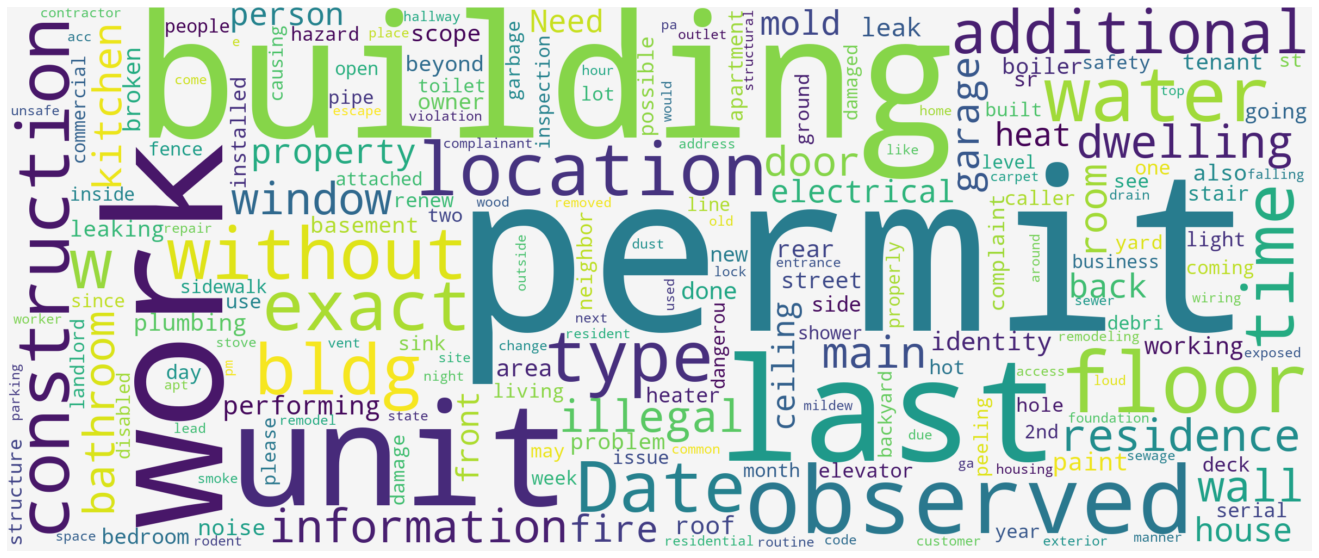

In [103]:
text = " ".join(complaint for complaint in df.complaint_description)
wordcloud = WordCloud(stopwords=stop_words, background_color="whitesmoke",
                     collocations = False, width=2400, height=1000).generate(text)

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


<h1>Most Common Word Pairs</h1>

<div class="description">
Next we'll create a wordcloud to show the most common word pairs that were found in the complaints.
</div>

(-0.5, 2399.5, 999.5, -0.5)

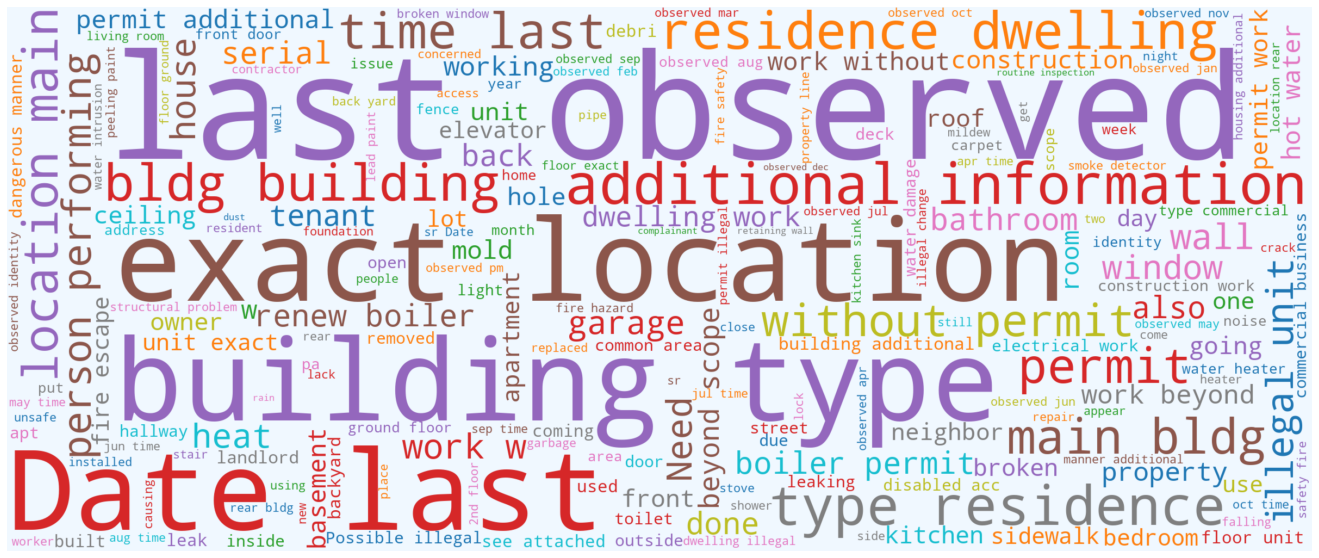

In [104]:
text = " ".join(complaint for complaint in df.complaint_description)
wordcloud = WordCloud(stopwords=stop_words, background_color="aliceblue",
                     colormap = "tab10", width=2400, height=1000).generate(text)

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [105]:
#now we'll create a wordcloud for each class 
complaint_classes = np.unique(df['assigned_division'].values)

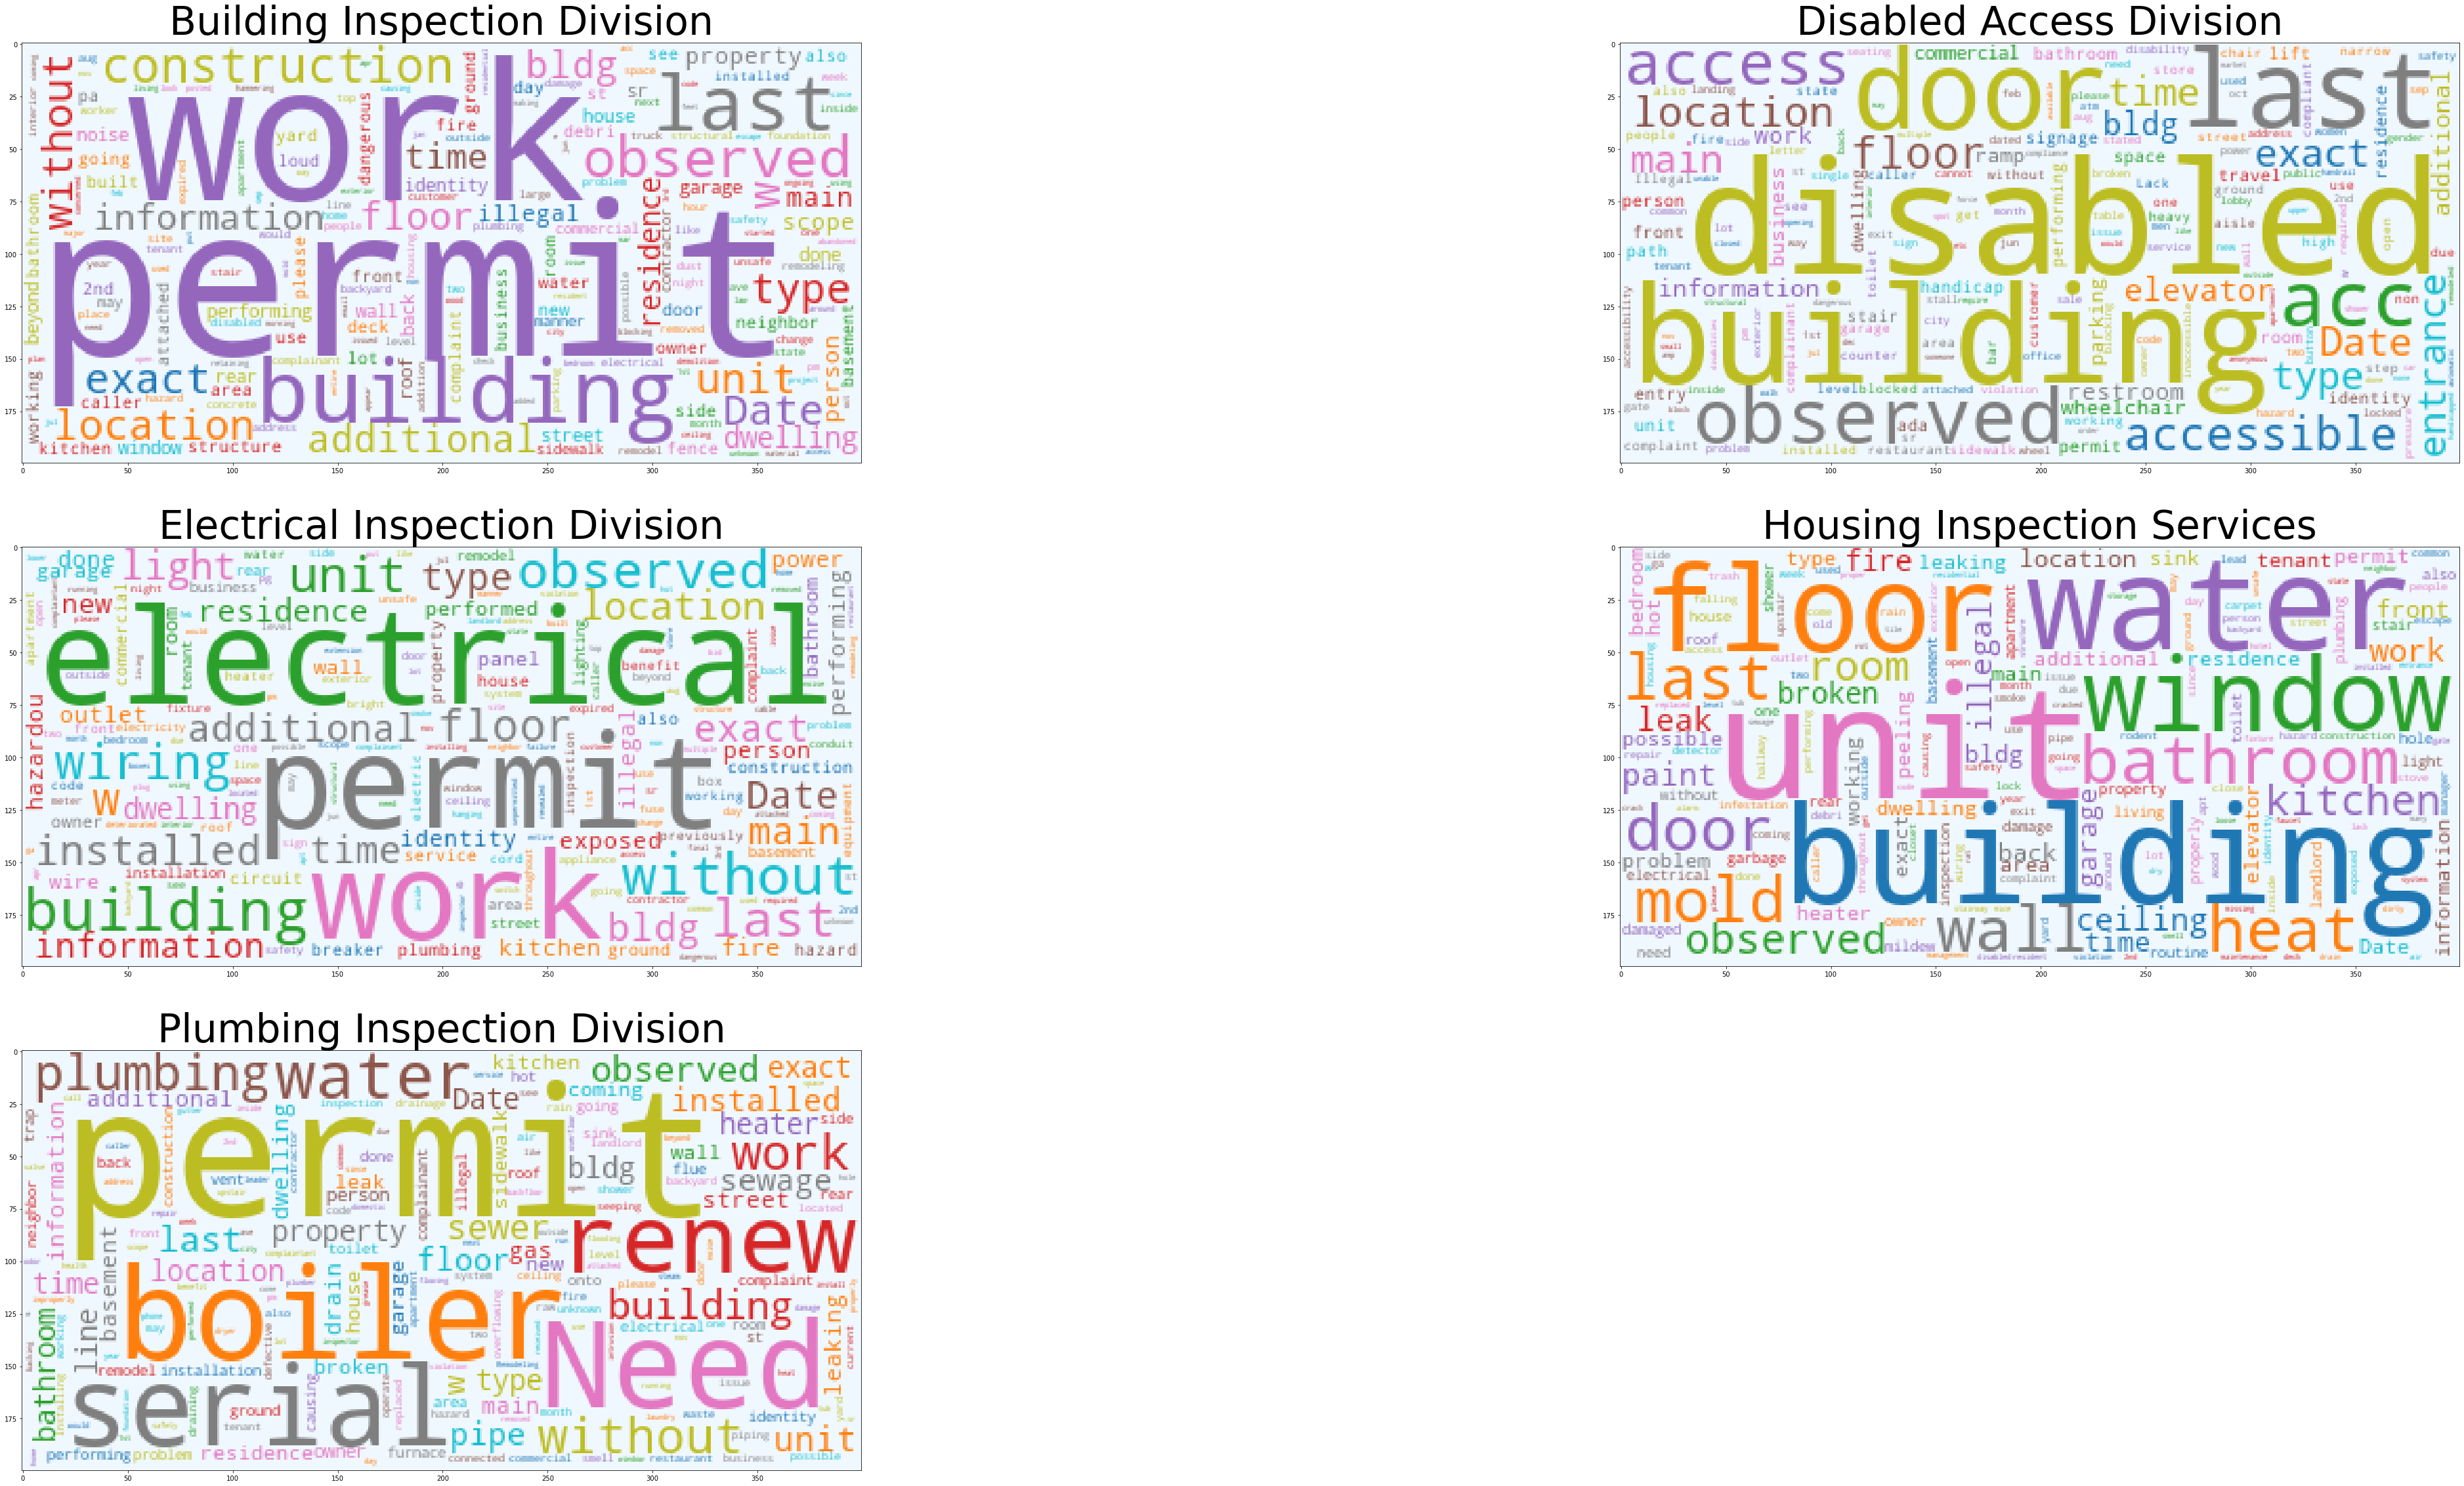

In [111]:
fig, axes = plt.subplots(3,2, figsize=(80, 40))
axes = axes.flatten()
axes[5].remove()

for i, complaint_class in enumerate(complaint_classes):
    
    text = " ".join(complaint for complaint in df.loc[df['assigned_division'] \
                    == complaint_class].complaint_description)

    wordcloud = WordCloud(stopwords=stop_words,background_color="aliceblue",
                          collocations = False,colormap = "tab10").generate(text)
    
    axes[i].imshow(wordcloud,interpolation='none')
    axes[i].set_title(complaint_class, size = 60)

<div class="description">
Finally we will save the preprocessed data in our /data/ directory.
In the clean_data notebook we will create stemmed and lemmatized versions of 
the data before tokenizing it with Tensorflow's tokenizer. 
</div>

In [107]:
#finally we save the preprocessed data to our data subdirectory 
#next we will stem or lemmatize the text before tokenizing it via Tensorflow
preprocessed = df.copy()
preprocessed.to_csv(data_path + '/preprocessed.csv',index = False)